> <center><h2>Identifying mental health disorders Artificial Intelligence using Natural Language Processing & Deep Learning Techniques</h2>
> <br><h3>Zacharias Siatris</h3>
> <h3>MSc in Artificial Intelligence
    The University of Bath<br>2022 - 2023</h3></center><br><br><br>

### Import Dependencies (under development)

- [pandas](https://pandas.pydata.org/) - library that we will use for loading and displaying the data in a table
- [numpy](http://www.numpy.org/) - library that we will use for linear algebra operations
- [matplotlib](https://matplotlib.org/) - library that we will use for plotting the data
- [math](https://docs.python.org/3/library/math.html) - math library that we will use to calculate sqaure roots etc.
- [neural_network](https://github.com/trekhleb/homemade-machine-learning/blob/master/homemade/neural_network/multilayer_perceptron.py) - custom implementation of multilayer perceptron

In [1]:
!pip install nltk
!pip install tensorflow
!pip install transformers
!pip install scikeras
!pip install wordcloud
!pip install packaging


import time
import pandas as pd
import nltk
import re, string
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import distutils


from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.utils import np_utils

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from transformers import pipeline

from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

from collections import OrderedDict
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ZachariasSiatris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ZachariasSiatris\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ZachariasSiatris\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ZachariasSiatris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ZachariasSiatris\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

> Initializing the variables that will be later used for reporting and model-utilization purposes

- **`load_big_datasets`**: This boolean variable when set to 'True' will use the csv files that include more than 800K samples. 
<br><b><u>Warning:</u></b> Depending the machine you are executing this notebook it may take from 1-3 hours.


- **`use_nlp_validation_model`**: This boolean variable when set to 'True' will utilize the NLP validation model (Hugging Face) in order to apply sentiment analysis to the dataset. 
<br><b><u>Warning:</u></b> It requires a lot of time due to the use of API calls. In case you selected to load the big datasets, **<font color=#FF0000>make sure you set this variable to 'False' </font>**.


- **`print_word_cloud_per_disorder`**: This boolean variable when set to 'True' will print at the last section "Results & Visualizations" a bag of words included in each mental health disorder using Word Cloud.


- **`print_dataset_each_step`**: This boolean variable when set to 'True' will print the dataframe object at each step during the NLP development.


- **`number_of_rows_to_print`**: This number regards to the "print_dataset_each_step" variable and sets the number of rows of the dataframe object to be printed on each step. 

In [2]:
pd.set_option('display.colheader_justify', 'center')
pd.set_option('expand_frame_repr', False)
np.set_printoptions(suppress=True)

english_stop_words = stopwords.words('english')
 

load_big_datasets = False    
use_nlp_validation_model = False


print_word_cloud_per_disorder = False
print_dataset_each_step = False
number_of_rows_to_print = 20

> <br><br><center><h1>Mental Health Disorder Datasets</h1><br><br>

In [3]:
if load_big_datasets:
    files = 'CSV_Files_Large_Datasets'
else:
    files = 'CSV_Files_Small_Datasets'


BPD_dataframe = pd.read_csv('Datasets/' + files + '/BPD_Disorder_Dataset.csv')
ANXIETY_dataframe = pd.read_csv('Datasets/' + files + '/Anxiety_Disorder_Dataset.csv')
BIPOLAR_dataframe = pd.read_csv('Datasets/' + files + '/Bipolar_Disorder_Dataset.csv')
DEPRESSION_dataframe = pd.read_csv('Datasets/' + files + '/Depression_Disorder_Dataset.csv')
EATING_dataframe = pd.read_csv('Datasets/' + files + '/Eating_Disorder_Dataset.csv')
GENERAL_dataframe = pd.read_csv('Datasets/' + files + '/General_Mental_Illnesses_Disorder_Dataset.csv')
PSYCHOTIC_dataframe = pd.read_csv('Datasets/' + files + '/Schizophrenia_Disorder_Dataset.csv')
GENDER_dataframe = pd.read_csv('Datasets/' + files + '/Sexual_and_Gender_Identity_Disorder_Dataset.csv')


# Merging dataframes
merged_dataframes = [BPD_dataframe, 
                     ANXIETY_dataframe, 
                     BIPOLAR_dataframe,
                     DEPRESSION_dataframe, 
                     EATING_dataframe, 
                     GENERAL_dataframe, 
                     PSYCHOTIC_dataframe, 
                     GENDER_dataframe]

# Resetting the index of the consolidated dataset
merged_dataframes = pd.concat(merged_dataframes).reset_index(drop=True)

# Removing samples where values are empty
merged_dataframes = merged_dataframes.dropna()

> <br><br><center><h1>Natural Language Processing (Validation Model)</h1><br><br>

In [4]:
def validation_nlp(dataframe):
    
    # This is where the second nlp model (validation) is used for sentiment analysis. If the use_nlp_validation is True
    # it will execute the code, else it will move on to the last sentence to return the dataframe
    if use_nlp_validation_model:
        
        print("\n\nVALIDATION NLP Model for Sentiment Analysis has been initiated\n")
        
        
        # Using transformers NLP model to classify the context of being positive or negative  
        # Method from hugging face (transformers) that uses a pre-trained NLP model to classify a context as positive or negative
        sentiment_classifier = pipeline("sentiment-analysis")
        dataframe['sentiment'] = [sentiment_classifier(' '.join(row), max_length=512)[0].get('label') for row in dataframe['text']]

        # Removing rows from the dataset where the sentiment analysis is positive
        dataframe.drop(dataframe[(dataframe['sentiment'] == 'POSITIVE')].index, inplace=True)
        
        print_dataset(dataframe) 
    
    return dataframe

> <br><br><center><h1>Natural Language Processing (Implementation Model)</h1><br><br>

In [5]:
# Method to remove contractions
def removing_contractions(line):
    
    # lines with special character (')
    line = line.replace("’", "'")
    
    # Replacing abbreviations for mental health disorders
    line = re.sub(" aspd ", " antisocial personality disorder ", line)
    line = re.sub(" add ", " attention deficit disorder ", line)
    line = re.sub(" adhd ", " attention deficit hyperactivity disorder ", line)
    line = re.sub(" avpd ", " avoidant personality disorder ", line)
    line = re.sub(" bdd ", " body dysmorphic disorder ", line)
    line = re.sub(" bpd ", " borderline personality disorder ", line)
    line = re.sub(" crsd ", " circadian rhythm sleep disorder ", line)
    line = re.sub(" ednos ", " eating disorder not otherwise specified ", line)
    line = re.sub(" gad ", " generalized anxiety disorder ", line)
    line = re.sub(" nes ", " night eating syndrome ", line)
    line = re.sub(" mdd ", " major depressive disorder ", line)
    line = re.sub(" ocd ", " obsessive-compulsive disorder ", line)
    line = re.sub(" odd ", " oppositional defiant disorder ", line)
    line = re.sub(" ppd ", " paranoid personality disorder ", line)
    line = re.sub(" pted ", " post traumatic embitterment disorder ", line)
    line = re.sub(" ptsd ", " post traumatic stress disorder ", line)
    line = re.sub(" sza ", " schizoaffective disorder ", line)
    line = re.sub(" spd ", " schizoid personality disorder ", line)


    # Replacing top slang words used in tweets, posts, etc.
    line = re.sub(" imma ", " I am going to ", line)
    line = re.sub(" wanna ", " I want to ", line)
    line = re.sub(" lemme ", " let me ", line)
    line = re.sub(" kinda ", " kind of ", line)
    line = re.sub(" init ", " is not it ", line)
    line = re.sub(" gotta ", " got to ", line)
    line = re.sub(" gonna ", " going to ", line)
    line = re.sub(" gona ", " going to ", line)
    line = re.sub(" gimme ", " give me ", line)
    line = re.sub(" yr ", " year ", line)
    line = re.sub(" yrs ", " years ", line)
    line = re.sub(" bc ", " because ", line)
    line = re.sub(" cuz ", " because ", line)
    line = re.sub("idk", " I do not know ", line)
    line = re.sub(" bf ", " boyfriend ", line)
    line = re.sub(" gf ", " girlfriend ", line)
    line = re.sub(" dae ", " does anybody else ", line)
    line = re.sub(" fp ", " favourite person ", line)


    # Replacing abbreviations in English language
    line = re.sub(r"ain't", "is not", line)
    line = re.sub(r"aren't", "are not", line)
    line = re.sub(" arent ", " are not ", line)
    line = re.sub(r"can't", "cannot", line)
    line = re.sub(" cant ", " cannot ", line)
    line = re.sub(r"can't've", "cannot have", line)
    line = re.sub(" cause ", "because", line)
    line = re.sub(r"could've", "could have", line)
    line = re.sub(r"couldn't", "could not", line)
    line = re.sub(" couldnt ", " could not ", line)
    line = re.sub(r"couldn't've", "could not have", line)
    line = re.sub(r"didn't", "did not", line)
    line = re.sub(" didnt ", " did not ", line)
    line = re.sub(r"doesn't", "does not", line)
    line = re.sub(" doesnt ", " does not ", line)
    line = re.sub(r"don't", "do not", line)
    line = re.sub(" dont ", " do not ", line)
    line = re.sub(r"hadn't", "had not", line)
    line = re.sub(" hadnt ", " had not ", line)
    line = re.sub(r"hadn't've", "had not have", line)
    line = re.sub(r"hasn't", "has not", line)
    line = re.sub(" hasnt ", " has not ", line)
    line = re.sub(r"haven't", "have not", line)
    line = re.sub(" havent ", " have not ", line)
    line = re.sub(r"he'd", "he would", line)
    line = re.sub(r"he'd've", "he would have", line)
    line = re.sub(r"he'll", "he will", line)
    line = re.sub(r"he'll've", "he he will have", line)
    line = re.sub(r"he's", "he is", line)
    line = re.sub(r"how'd", "how did", line)
    line = re.sub(r"how'd'y", "how do you", line)
    line = re.sub(r"how'll", "how will", line)
    line = re.sub(r"how's", "how is", line)
    line = re.sub(" hows ", " how is ", line)
    line = re.sub(r"i'd", "i would", line)
    line = re.sub(r"i'd've", "i would have", line)
    line = re.sub(r"i'll", "i will", line)
    line = re.sub(r"i'll've", "i will have", line)
    line = re.sub(r"i'm", "i am", line)
    line = re.sub(" im ", " i am ", line)
    line = re.sub(r"i've", "i have", line)
    line = re.sub(" ive ", " i have ", line)
    line = re.sub(r"isn't", "is not", line)
    line = re.sub(" isnt ", " is not ", line)
    line = re.sub(r"it'd", "it would", line)
    line = re.sub(r"it'd've", "it would have", line)
    line = re.sub(r"it'll", "it will", line)
    line = re.sub(r"it'll've", "it will have", line)
    line = re.sub(r"it's", "it is", line)
    line = re.sub(r"let's", "let us", line)
    line = re.sub(" lets ", " let us ", line)
    line = re.sub(r"ma'am", "madam", line)
    line = re.sub(r"mayn't", "may not", line)
    line = re.sub(r"might've", "might have", line)
    line = re.sub(r"mightn't", "might not", line)
    line = re.sub(r"mightn't've", "might not have", line)
    line = re.sub(r"must've", "must have", line)
    line = re.sub(r"mustn't", "must not", line)
    line = re.sub(" mustnt ", " must not ", line)
    line = re.sub(r"mustn't've", "must not have", line)
    line = re.sub(r"needn't", "need not", line)
    line = re.sub(" neednt ", " need not ", line)
    line = re.sub(r"needn't've", "need not have", line)
    line = re.sub("no where", "nowhere", line)
    line = re.sub(r"o'clock", "of the clock", line)
    line = re.sub("oclock", "of the clock", line)
    line = re.sub(r"oughtn't", "ought not", line)
    line = re.sub(r"oughtn't've", "ought not have", line)
    line = re.sub(r"shan't", "shall not", line)
    line = re.sub(r"sha'n't", "shall not", line)
    line = re.sub(r"shan't've", "shall not have", line)
    line = re.sub(r"she'd", "she would", line)
    line = re.sub(r"she'd've", "she would have", line)
    line = re.sub(r"she'll", "she will", line)
    line = re.sub(r"she'll've", "she will have", line)
    line = re.sub(r"she's", "she is", line)
    line = re.sub(r"should've", "should have", line)
    line = re.sub(r"shouldn't", "should not", line)
    line = re.sub(" shouldnt ", " should not ", line)
    line = re.sub(r"shouldn't've", "should not have", line)
    line = re.sub(r"so've", "so have", line)
    line = re.sub(r"so's", "so as", line)
    line = re.sub(r"that'd", "that would", line)
    line = re.sub(r"that'd've", "that would have", line)
    line = re.sub(r"that's", "that is", line)
    line = re.sub(" thats ", " that is ", line)
    line = re.sub(r"there'd", "there would", line)
    line = re.sub(r"there'd've", "there would have", line)
    line = re.sub(r"there's", "there is", line)
    line = re.sub(" theres ", "there is", line)
    line = re.sub(r"they'd", "they would", line)
    line = re.sub(r"they'd've", "they would have", line)
    line = re.sub(r"they'll", "they will", line)
    line = re.sub(r"they'll've", "they will have", line)
    line = re.sub(r"they're", "they are", line)
    line = re.sub(r"they've", "they have", line)
    line = re.sub(r"to've", "to have", line)
    line = re.sub(r"wasn't", "was not", line)
    line = re.sub(" wasnt ", " was not ", line)
    line = re.sub(r"we'd", "we would", line)
    line = re.sub(r"we'd've", "we would have", line)
    line = re.sub(r"we'll", "we will", line)
    line = re.sub(r"we'll've", "we will have", line)
    line = re.sub(r"we're", "we are", line)
    line = re.sub(r"we've", "we have", line)
    line = re.sub(r"weren't", "were not", line)
    line = re.sub(r" werent ", " were not ", line)
    line = re.sub(r"what'll", "what will", line)
    line = re.sub(r"what'll've", "what will have", line)
    line = re.sub(r"what're", "what are", line)
    line = re.sub(r"what's", "what is", line)
    line = re.sub(r" whats ", " what is ", line)
    line = re.sub(r"what've", "what have", line)
    line = re.sub(r"when's", "when is", line)
    line = re.sub(r"when've", "when have", line)
    line = re.sub(r"where'd", "where did", line)
    line = re.sub(r"where's", "where is", line)
    line = re.sub(r"where've", "where have", line)
    line = re.sub(r"who'll", "who will", line)
    line = re.sub(r"who'll've", "who will have", line)
    line = re.sub(r"who's", "who is", line)
    line = re.sub(r"who've", "who have", line)
    line = re.sub(r"why's", "why is", line)
    line = re.sub(r"why've", "why have", line)
    line = re.sub(r"will've", "will have", line)
    line = re.sub(r"won't", "will not", line)
    line = re.sub(" wont ", " will not ", line)
    line = re.sub(r"won't've", "will not have", line)
    line = re.sub(r"would've", "would have", line)
    line = re.sub(r"wouldn't", "would not", line)
    line = re.sub(r" wouldnt ", " would not ", line)
    line = re.sub(r"wouldn't've", "would not have", line)
    line = re.sub(r"y'all", "you all", line)
    line = re.sub(r"y'all'd", "you all would", line)
    line = re.sub(r"y'all'd've", "you all would have", line)
    line = re.sub(r"y'all're", "you all are", line)
    line = re.sub(r"y'all've", "you all have", line)
    line = re.sub(r"you'd", "you would", line)
    line = re.sub(r"you'd've", "you would have", line)
    line = re.sub(r"you'll", "you will", line)
    line = re.sub(r"you'll've", "you will have", line)
    line = re.sub(r"you're", "you are", line)
    line = re.sub(r" youre ", " you are ", line)
    line = re.sub(r"you've", "you have", line)
    line = re.sub("etc", " ", line)

    return line



# function to remove non-ASCII
def remove_non_ascii(text):
    return ''.join(char for char in text if ord(char) < 128)



# Method to clear out rows with empty cells, replace non-ASCII characters and remove contractions
def pre_processing_data(dataframe):
    # Deleting rows from the dataset where rows are empty
    dataframe = dataframe.dropna()

    # Deleting duplicate rows from the dataset
    dataframe = dataframe.drop_duplicates()

    # Applying ASCII encoding first flagging data with errors="ignore" flag, then subsequently decoding it into ASCII
    dataframe['text'] = dataframe['text'].apply(remove_non_ascii)

    # Removing newline characters
    dataframe['text'] = dataframe['text'].replace(r'\n', ' ', regex=True)

    # Removing the character reference "An ampersand"
    dataframe['text'] = dataframe['text'].replace('&amp;', ' ', regex=True)

    # Converts uppercase characters to lowercase
    dataframe['text'] = dataframe['text'].str.lower()

    # Replacing contractions to original words
    dataframe['text'] = dataframe['text'].apply(removing_contractions)

    return dataframe



# Method to tokenize the text into tokens (words)
def tokenize_dataframe(dataframe):
    for index, row in dataframe.iterrows():
        row['text'] = nltk.word_tokenize(row['text'])

    return dataframe



# Method to lemmatize each word in the text column of the dataframe
def lemmatize_sentence(dataframe):
    lemmatizer = WordNetLemmatizer()

    for index, row in dataframe.iterrows():
        lemmatized_phrase = []

        for word, tag in pos_tag(row['text']):
            if tag.startswith('NN'):
                pos = 'n'
            elif tag.startswith('VB'):
                pos = 'v'
            else:
                pos = 'a'
            lemmatized_phrase.append(lemmatizer.lemmatize(word, pos))
            
        dataframe.at[index, 'text'] = " ".join(lemmatized_phrase)

    return dataframe



# Method to remove emoticons, flags and special characters
def remove_emojis(line):
    emoj = re.compile("["
                      u"\U0001F600-\U0001F64F"  # emoticons
                      u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                      u"\U0001F680-\U0001F6FF"  # transport & map symbols
                      u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                      u"\U00002500-\U00002BEF"  # chinese char
                      u"\U00002702-\U000027B0"
                      u"\U000024C2-\U0001F251"
                      u"\U0001f926-\U0001f937"
                      u"\U00010000-\U0010ffff"
                      u"\u2640-\u2642"
                      u"\u2600-\u2B55"
                      u"\u200d"
                      u"\u23cf"
                      u"\u23e9"
                      u"\u231a"
                      u"\ufe0f"
                      u"\u3030"
                      "]+", re.UNICODE)

    return re.sub(emoj, '', line)



# Method to remove noise from the data (meaning: stop words, emojis and special characters, urls, etc.)
def remove_noise(dataframe, stop_words):
    dataframe['text'] = dataframe['text'].str.replace('\d+', '', regex=True)
    dataframe['text'] = dataframe['text'].str.replace('\W', ' ', regex=True)
    dataframe['text'] = dataframe['text'].apply(lambda x: re.split('http.*', str(x))[0])
    
    for index, row in dataframe.iterrows():
        cleaned_phrase = []

        for word in row['text'].split():
            word = re.sub('(@[A-Za-z0-9_]+)', '', word)
            word = remove_emojis(word)

            if len(word) >= 1 and word not in string.punctuation and word not in stop_words:
                cleaned_phrase.append(word)

        dataframe.at[index, 'text'] = " ".join(cleaned_phrase)

    return dataframe



# Method to unify words into text and remove duplicates. Also it removes rows that have only few words as context (
# using 10 as minimum threshold)
def remove_rows_with_few_words(dataframe):

    dataframe['text'] = (dataframe['text'].str.split().apply(lambda x: OrderedDict.fromkeys(x).keys()).str.join(' '))
    dataframe = dataframe.loc[dataframe['text'].str.count(' ').gt(10)]

    return dataframe


# TfidfVectorizer
def create_tfidf_model(dataframe):

    tfidf_vectorizer = TfidfVectorizer(min_df=0.02, max_df=0.98, ngram_range=(1, 2), stop_words='english')
    X = dataframe['text']
    Y = dataframe['mental_health_disorder']

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

    X_train = tfidf_vectorizer.fit_transform(X_train).todense()
    X_test = tfidf_vectorizer.transform(X_test).todense()

    # print(pd.DataFrame(X_train, columns = vectorizer.get_feature_names_out()))    

    return X_train, X_test, Y_train, Y_test, tfidf_vectorizer



def print_dataset(dataframe):
    if print_dataset_each_step:
        print("Printing first " + str(number_of_rows_to_print) + " rows of the dataframe:\n")
        print(dataframe.head(number_of_rows_to_print))

<br><br>Below you may find the method that includes and consolidates all the NLP processing steps into one for developing the NLP model

In [6]:
def initiate_nlp(dataframe):
    
    print("\n\nMain NLP Model has been initiated\n")
    print_dataset(dataframe)

    
    # Starting with the first method for processing the data (STEP 1)
    print("\n  - STEP 1 STARTED: Pre-processing dataset\n")
    dataframe = pre_processing_data(dataframe)
    print_dataset(dataframe)
    
    
    # Tokenizing the data (STEP 2)
    print("\n\n  - STEP 2 STARTED: Tokenizing dataset\n")
    dataframe = tokenize_dataframe(dataframe)
    print_dataset(dataframe)
    

    # Lemmatizing the data of the dataframe (STEP 3)
    print("\n\n  - STEP 3 STARTED: Lemmatizing dataset\n")
    dataframe = lemmatize_sentence(dataframe)
    print_dataset(dataframe)
    

    # Removing noise (STEP 4)
    print("\n\n  - STEP 4 STARTED: Removing noise from the dataset\n")
    dataframe = remove_noise(dataframe, english_stop_words)
    print_dataset(dataframe)
    

    # Deleting rows after the processing where cells are empty (if any)
    dataframe = dataframe.dropna()
    
    
    # Removing rows with few words as context (STEP 5)
    print("\n\n  - STEP 5 STARTED: Removing rows with few words from the dataset\n")
    dataframe = remove_rows_with_few_words(dataframe)
    print_dataset(dataframe)   
    
    
    # Removing rows with few words as context (STEP 6)
    print("\n\n  - STEP 6 STARTED: Term Frequency-Inverse Document Frequency\n\n\n")
    X_train, X_test, Y_train, Y_test, tfidf_vectorizer = create_tfidf_model(dataframe)
    print_dataset(dataframe)   


    return X_train, X_test, Y_train, Y_test, tfidf_vectorizer

> <br><br><center><h1>Deep Learning Model</h1><br><br>

This is the place where you might want to play with model configuration. Be aware though that the training of the neural network with current parameters may take up to 15 minutes depending on the hardware. 

- **`random.seed`**:  This seed generator is used to make sure that the same sequences of numbers will be allocated and therefore, achieve reproducibility.
- **`number_of_classes`**: This parameter represents the total number of unique classes (or labels) of the dataset. It is dynamic; meaning it gets automatically the unique number of the mental health labels of the consolidated datasets. By doing this, the LabelEncoder method creates the relevant numerical values for each categorigal mental health label.
- **`batch_size`**: This parameter defines the volume of data that will be propagated through the deep learning network.
- **`number_of_epochs`**: This parameter sets the number of complete passes through the training dataset. In other words, it is the number of one forward pass and one backward pass of the training dataset.

In [7]:
# Parameters for Deep Learning Model
np.random.seed(0)
number_of_classes = len(merged_dataframes["mental_health_disorder"].unique())
batch_size = 64
number_of_epochs = 20
    


# Method for building the Deep Learning Model
def build_deep_learning_model():
    
    model = Sequential()
    model.add(Dense(1000))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(500))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(number_of_classes))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model


# Method for testing the Deep Learning Model
def test_deep_learning_model(X_train, X_test, Y_train, Y_test, deep_learning_model, encoder):
    
    # Predicting mental health labels for both training and testing datasets
    y_train_predictions = deep_learning_model.predict(X_train, batch_size)
    y_test_predictions = deep_learning_model.predict(X_test, batch_size)

    
    ''' 
    * From the list of the predictions argmax is used to get the label(index) with the highest probability. This way 
      a comparison between this and the real label takes place to calculate the accuracy.
    
    * The for-loop is used to convert the indexed values to the real categorical label (text) from the list of classes (labels)
    '''
    y_train_predicted_max_values = np.argmax(y_train_predictions, axis=1)
    y_train_predicted_max_values = [encoder.classes_[i] for i in y_train_predicted_max_values]

    y_test_predicted_max_values = np.argmax(y_test_predictions, axis=1)
    y_test_predicted_max_values = [encoder.classes_[i] for i in y_test_predicted_max_values]
    
    
    # Storing results to variables to be able to visualize and report them later in this notebook
    train_score = round(accuracy_score(Y_train, y_train_predicted_max_values), 4)
    train_report = classification_report(Y_train, y_train_predicted_max_values)
    
    test_score = round(accuracy_score(Y_test, y_test_predicted_max_values), 4)
    test_report = classification_report(Y_test, y_test_predicted_max_values)
    
    results = train_score, train_report, test_score, test_report
    
    return results

<br><br>Below you may find the method that includes and consolidates all the Deep Learning steps into one for developing the Deep Learning model

In [8]:
def initiate_deep_learning(X_train, X_test, Y_train, Y_test):
    
    # Encoding method to convert categorical values (labels) to numerical ones
    encoder = LabelEncoder()
    encoder.fit(Y_train)
    encoded_Y = encoder.transform(Y_train)
    y_encoded_train = np_utils.to_categorical(encoded_Y, number_of_classes)
    
    
    # Building Deep Learning Model
    deep_learning_model = build_deep_learning_model()
    
    
    # Training Deep Learning Model
    # "history" variable is used to save the results of the training performance
    model_history = deep_learning_model.fit(X_train, y_encoded_train, batch_size, number_of_epochs, verbose=1)
    
    
    # Testing Deep Learning Model
    results = test_deep_learning_model(X_train, X_test, Y_train, Y_test, deep_learning_model, encoder)
    
    return model_history, results

<br><br>Below you may find the main method that includes the following steps:

- Developing the first NLP model (Validation Model)
- Developing the second NLP model (Implementation Model)
- Developing the Deep Learning model (Multi-label Classification)

In [9]:
start_time = time.time()


merged_dataframes = validation_nlp(merged_dataframes)

X_train, X_test, Y_train, Y_test, tfidf_vectorizer = initiate_nlp(merged_dataframes)

model_history, results = initiate_deep_learning(X_train, X_test, Y_train, Y_test)


end_time = time.time()



Main NLP Model has been initiated


  - STEP 1 STARTED: Pre-processing dataset



  - STEP 2 STARTED: Tokenizing dataset



  - STEP 3 STARTED: Lemmatizing dataset



  - STEP 4 STARTED: Removing noise from the dataset



  - STEP 5 STARTED: Removing rows with few words from the dataset



  - STEP 6 STARTED: Term Frequency-Inverse Document Frequency



Epoch 1/20
85/85 [==============================] - 2s 14ms/step - loss: 0.4146 - accuracy: 0.1765
Epoch 2/20
85/85 [==============================] - 1s 13ms/step - loss: 0.2972 - accuracy: 0.4594
Epoch 3/20
85/85 [==============================] - 1s 14ms/step - loss: 0.2304 - accuracy: 0.6071
Epoch 4/20
85/85 [==============================] - 1s 14ms/step - loss: 0.1974 - accuracy: 0.6830
Epoch 5/20
85/85 [==============================] - 1s 14ms/step - loss: 0.1745 - accuracy: 0.7254
Epoch 6/20
85/85 [==============================] - 1s 14ms/step - loss: 0.1520 - accuracy: 0.7738
Epoch 7/20
85/85 [==============================

<br><br><br><br><br>Below the **total execution time** of the flow is calculated:

In [10]:
total_time = end_time - start_time

print("\n********************************************************************************************\n")
print("Total time in seconds: " + str(round(total_time)))
print("Total time in minutes: " + str(round(total_time/60, 1)))
print("Total time in hours: " + str(round(total_time/3600)))

print("\nTOTAL TIME: " + str(round(total_time/3600)) + " hour(s) " 
                     + str(round((total_time%3600)/60)) + " minute(s) " 
                     + str(round(total_time%60)) + " second(s)")


********************************************************************************************

Total time in seconds: 80
Total time in minutes: 1.3
Total time in hours: 0

TOTAL TIME: 0 hour(s) 1 minute(s) 20 second(s)


> <br><br><center><h1> Results & Visualizations</h1><br><br>


Below you may find the **summary** of the deep learning model. This summary shows important information for understanding the architecture of the deep learning network and how data pass through layers.

In [11]:
model_history.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              495000    
                                                                 
 activation (Activation)     (None, 1000)              0         
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 activation_1 (Activation)   (None, 500)               0         
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               5

<br><br><br>Below you may find the **reports** regarding training and testing accuracy

In [12]:
print()
print('\033[1m' + 'Deep Neural Network\n' + '\033[0m')

print('\033[1m' + 'Train accuracy:' + '\033[0m' + str(results[0]))
print('Train Classification Report\n')
print(results[1])

print('\n\n***********************************\n\n')

print()
print('\033[1m' + 'Test accuracy:' + '\033[0m' + str(results[2]))
print('Test Classification Report\n')
print(results[3])


Deep Neural Network

Train accuracy:0.9989
Train Classification Report

                           precision    recall  f1-score   support

                  Anxiety       1.00      1.00      1.00       742
                  Bipolar       1.00      1.00      1.00       657
                      Bpd       1.00      1.00      1.00       792
               Depression       1.00      1.00      1.00       692
          Eating_disorder       1.00      1.00      1.00       423
Gender_Dysphoria_Disorder       1.00      1.00      1.00       737
         General_disorder       1.00      1.00      1.00       735
            Schizophrenia       1.00      1.00      1.00       638

                 accuracy                           1.00      5416
                macro avg       1.00      1.00      1.00      5416
             weighted avg       1.00      1.00      1.00      5416



***********************************



Test accuracy:0.596
Test Classification Report

                           prec

In [13]:
# print(pd.DataFrame(Y_train.astype(int), columns = encoder.classes_).head(10))

><h3>Training Loss</h3><br>

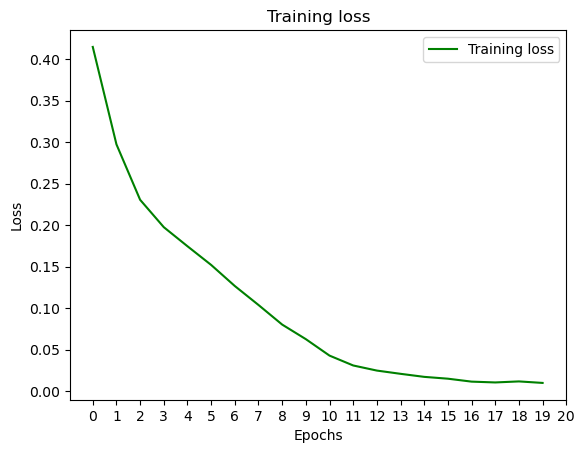

In [14]:
loss_train = model_history.history['loss']
epochs = range(0, number_of_epochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(np.arange(0, number_of_epochs + 1, 1))
plt.show()

><h3>Training Accuracy</h3><br>

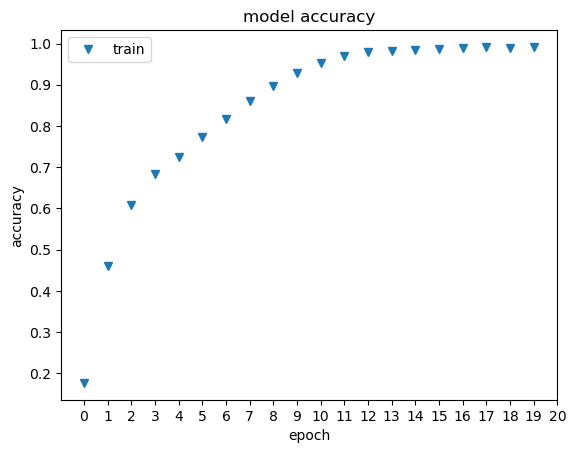

In [15]:
plt.plot(model_history.history['accuracy'], 'v')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.xticks(np.arange(0, number_of_epochs + 1, 1))
plt.show()

>Method to create plot with the most used words per mental health disorder. <br><br> A <b>word cloud</b> is a data visualization technique that shows the most used words in a list given as input. If you wish to see the word cloud images make sure you set the variable <i>print_word_cloud_per_disorder</i> to <b>True</b>

In [16]:
def create_word_cloud(label):
    if print_word_cloud_per_disorder:
        features = " ".join(review for review in merged_dataframes.loc[merged_dataframes['mental_health_disorder'] == label].text)
        features = ' '.join(np.unique(features).tolist())
        wordcloud = WordCloud(max_font_size=40, max_words=100, background_color="white", stopwords=english_stop_words).generate(
            features) 
        plt.figure(figsize=[20, 10])
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

<br><br>Using <b>Word Cloud</b> to present the features of the Tf-IDF model

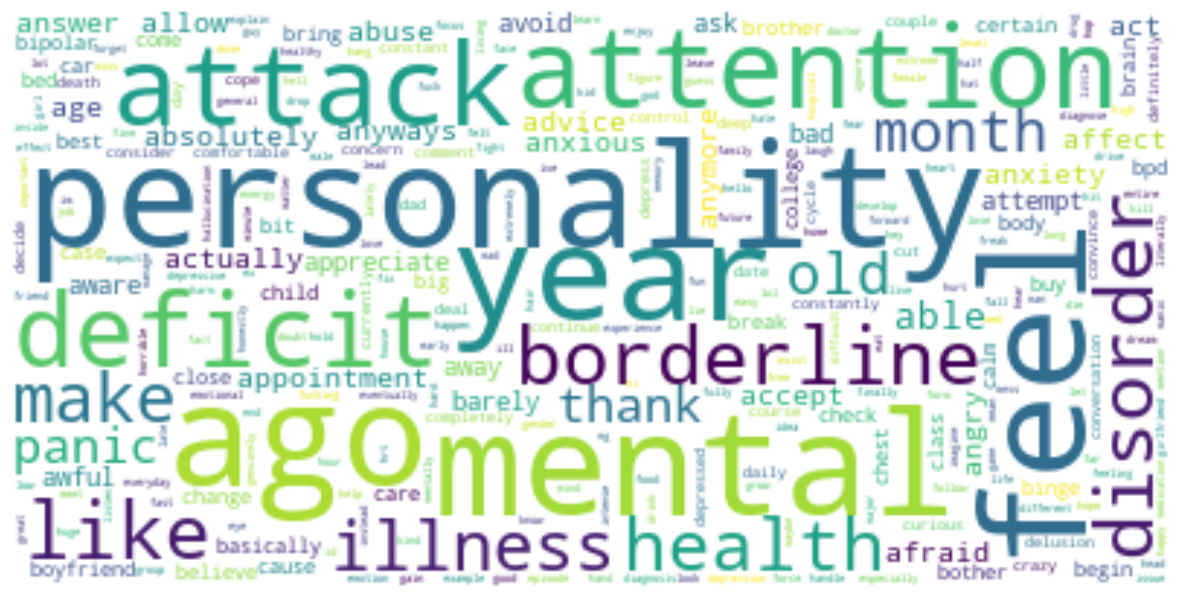

In [17]:
features = " ".join(review for review in tfidf_vectorizer.get_feature_names_out())
wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white", stopwords=english_stop_words).generate(
    features)
plt.figure(figsize=[15, 12])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<h3> ANXIETY DISORDER </h3>

In [18]:
create_word_cloud('Anxiety')

<h3> BIPOLAR DISORDER </h3>

In [19]:
create_word_cloud('Bipolar')

<h3> BORDERLINE PERSONALITY DISORDER </h3>

In [20]:
create_word_cloud('Bpd')

<h3> DEPRESSION DISORDER </h3>

In [21]:
create_word_cloud('Depression')

<h3> EATING DISORDER </h3>

In [22]:
create_word_cloud('Eating_disorder')

<h3> SCHIZOPHRENIA DISORDER </h3>

In [23]:
create_word_cloud('Schizophrenia')

<h3> SEXUAL & GENDER IDENTITY DISORDER </h3>

In [24]:
create_word_cloud('Gender_Dysphoria_Disorder')

<h3> GENERAL MENTAL HEALTH DISORDER </h3>

In [25]:
create_word_cloud('General_disorder')

<br><center><h2> Graphs showing number of contexts per mental health disorder</h2></center>

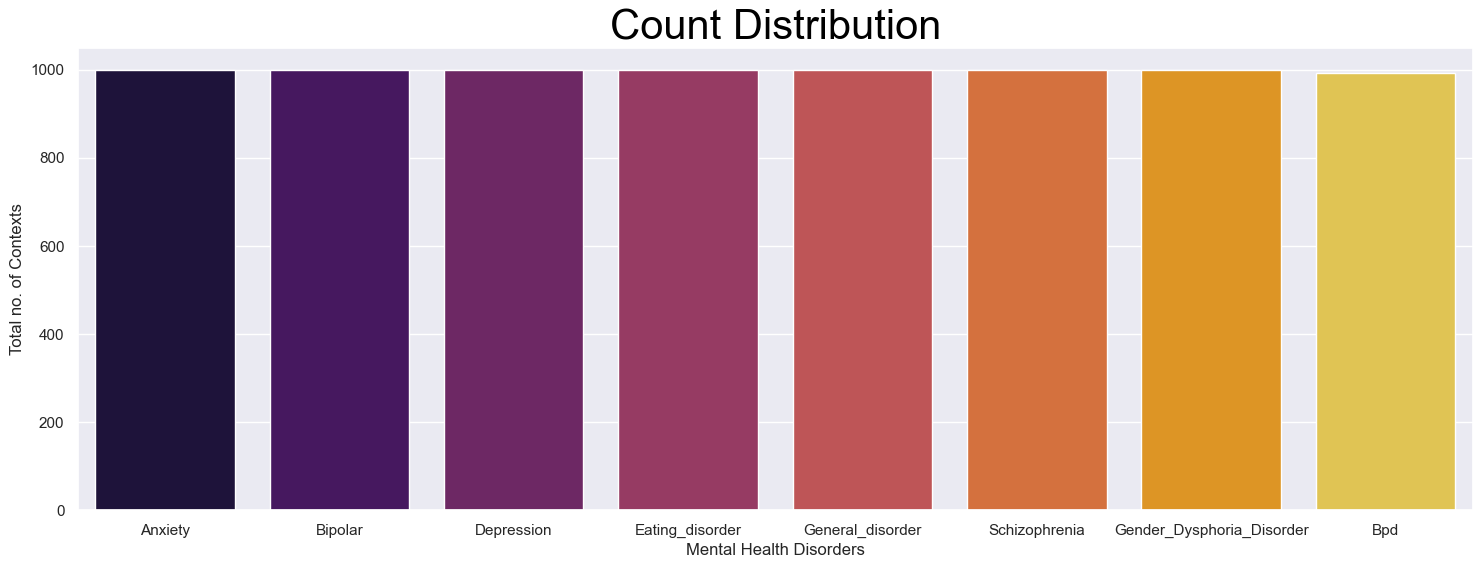

In [26]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=[18,6])
sns.countplot(data =  merged_dataframes,
              x = 'mental_health_disorder', 
              palette = 'inferno',
              order = merged_dataframes['mental_health_disorder'].value_counts().index,
              dodge = False)
plt.title('Count Distribution', fontdict={'fontsize': 30, 'fontweight': 5, 'color': 'Black'})
plt.xlabel("Mental Health Disorders")
plt.ylabel("Total no. of Contexts")
plt.show()

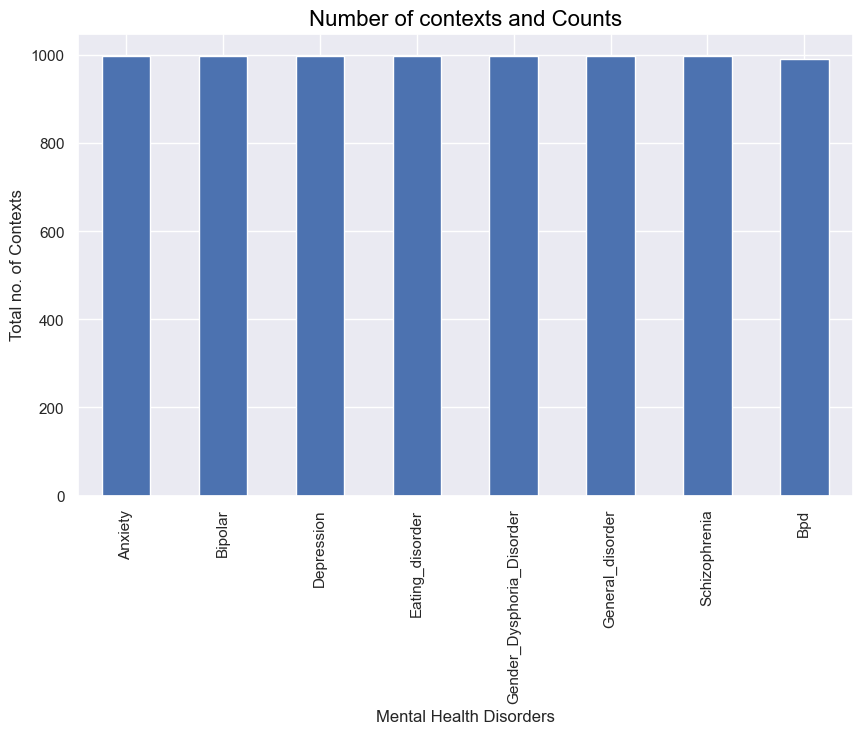

In [27]:
plt.figure(figsize=[10,6])
brand_counts = merged_dataframes.groupby('mental_health_disorder').count()['text'].sort_values(ascending=False)
brand_counts.plot.bar()
plt.title('Number of contexts and Counts', fontdict={'fontsize': 16, 'fontweight': 4, 'color': 'black'})
plt.xlabel("Mental Health Disorders")
plt.ylabel("Total no. of Contexts")
plt.show()